# Imports

In [157]:
import torch
import torch.nn as nn

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent

## main func

In [2]:
def main(minutes: int = 5,
         start_pos: np.array = [0.5, 0.5],
         getDF: bool = True):

    Env = Environment()
    Ag = Agent(Env)

    # agent configs
    Ag.pos = start_pos
    Ag.thigmotaxis = 0.2

    for i in range(int(minutes*60/Ag.dt)):
        Ag.update()
    explode_columns = ['pos', 'vel', 'head_direction']
    keep_columns = ['t', 'distance_travelled', 'rot_vel']

    if getDF:
        dfaux = pd.DataFrame(Ag.history)
        dfe = dfaux.explode(explode_columns, ignore_index=True)

        y_pos = [val for val in dfe[['pos']].values[1::2]]
        x_pos = [val for val in dfe[['pos']].values[0::2]]

        y_vel = [val for val in dfe[['vel']].values[1::2]]
        x_vel = [val for val in dfe[['vel']].values[0::2]]

        y_head_direction = [val for val in dfe[['head_direction']].values[1::2]]
        x_head_direction = [val for val in dfe[['head_direction']].values[0::2]]

        df = dfaux[keep_columns].copy()

        df['x_pos'] = [val[0] for val in x_pos]
        df['y_pos'] = [val[0] for val in y_pos]

        df['x_vel'] = [val[0] for val in x_vel]
        df['y_vel'] = [val[0] for val in y_vel]

        df['x_head_direction'] = [val[0] for val in x_head_direction]
        df['y_head_direction'] = [val[0] for val in y_head_direction]

        return df, Ag
    else:
        return Ag.history, Ag

In [3]:
df, ag = main(15,)
df.head()

,t,distance_travelled,rot_vel,x_pos,y_pos,x_vel,y_vel,x_head_direction,y_head_direction
0,0.05,0.003133,-1.458732,0.499976,0.503133,-0.000481,0.062654,-0.056279,0.998415
1,0.10,0.004810,-3.167472,0.500228,0.504791,0.005035,0.033160,0.012577,0.999921
2,0.15,0.006358,-3.251682,0.500705,0.506263,0.009541,0.029455,0.112230,0.993682
3,0.20,0.008360,-2.072604,0.501516,0.508094,0.016216,0.036616,0.211973,0.977276
4,0.25,0.009817,-1.242200,0.502187,0.509387,0.013428,0.025856,0.297268,0.954794


    • To AUTOMATICALLY save all plots (recommended), set  `ratinabox.autosave_plots = True`
    • To MANUALLY save plots, call                        `ratinabox.utils.save_figure(figure_object, save_title).
      This warning will not be shown again
HINT: You can stylize plots to make them look like repo/paper by calling `ratinabox.stylize_plots()`
      This hint will not be shown again


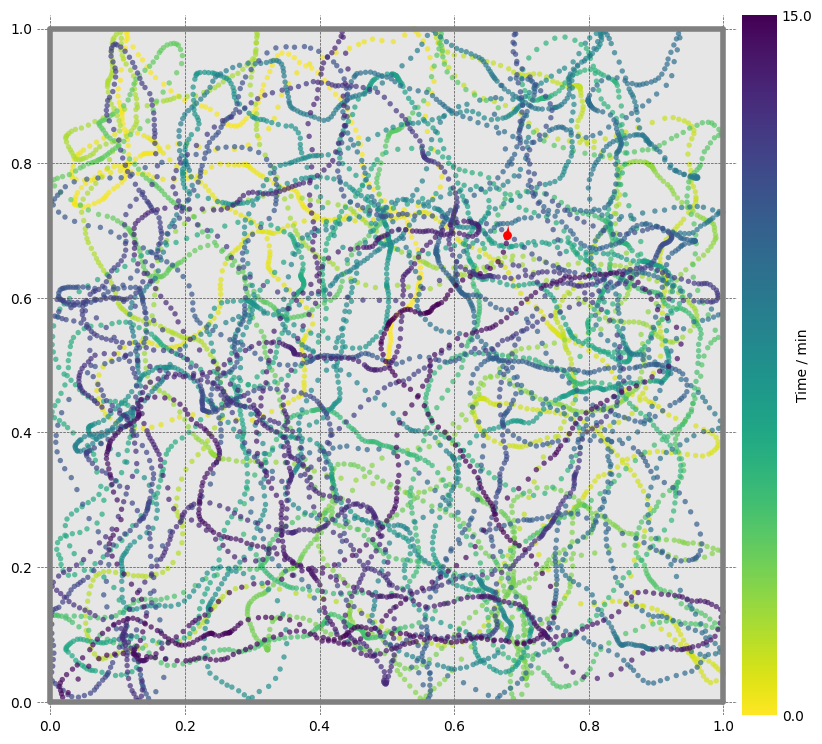

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(14,7))
ax = ag.plot_trajectory(color='changing', colorbar=True, gridlines=True,fig=fig, ax=ax)
plt.show()

# Dataset

### feature array

In [53]:
feature_array = []
for x_hd,y_hd, x_vl, y_vl in zip(df['x_head_direction'], df['y_head_direction'], df['x_vel'], df['y_vel'],):
        feature_array.append(torch.tensor([[x_hd, y_hd], [x_vl, y_vl]]))

feature_array = np.array(feature_array)
feature_array = torch.tensor(feature_array)

In [54]:
feature_array[:1], feature_array.shape

(tensor([[[-5.6279e-02,  9.9842e-01],
          [-4.8131e-04,  6.2654e-02]]]),
 torch.Size([18000, 2, 2]))

### target_array

In [55]:
target_array = []
for x_pos, y_pos in zip(df['x_pos'],	df['y_pos']):
    target_array.append(torch.tensor([x_pos, y_pos]))
target_array = np.array(target_array)
target_array = torch.tensor(target_array)

In [56]:
target_array[:1], target_array.shape

(tensor([[0.5000, 0.5031]]), torch.Size([18000, 2]))

In [57]:
n = int(len(df)*0.8)
x_train = feature_array[:n]
y_train = target_array[:n]

x_test = feature_array[n:]
y_test = target_array[n:]


print(f"{x_train.shape=}", f"{y_train.shape=}", f"{x_test.shape=}", f"{y_test.shape=}")

x_train.shape=torch.Size([14400, 2, 2]) y_train.shape=torch.Size([14400, 2]) x_test.shape=torch.Size([3600, 2, 2]) y_test.shape=torch.Size([3600, 2])


## train configs

In [58]:
block_size = 5 # 0.5s atras  #MUDAR PRA 10 depois (1s)

x_train[:block_size+1]

tensor([[[-5.6279e-02,  9.9842e-01],
         [-4.8131e-04,  6.2654e-02]],

        [[ 1.2577e-02,  9.9992e-01],
         [ 5.0346e-03,  3.3160e-02]],

        [[ 1.1223e-01,  9.9368e-01],
         [ 9.5413e-03,  2.9455e-02]],

        [[ 2.1197e-01,  9.7728e-01],
         [ 1.6216e-02,  3.6616e-02]],

        [[ 2.9727e-01,  9.5479e-01],
         [ 1.3428e-02,  2.5856e-02]],

        [[ 2.9072e-01,  9.5681e-01],
         [ 1.2746e-02,  4.4113e-02]]])

In [59]:
y_train[:block_size+1]

tensor([[0.5000, 0.5031],
        [0.5002, 0.5048],
        [0.5007, 0.5063],
        [0.5015, 0.5081],
        [0.5022, 0.5094],
        [0.5028, 0.5116]])

## Example Loop

In [64]:
df.head()

,t,distance_travelled,rot_vel,x_pos,y_pos,x_vel,y_vel,x_head_direction,y_head_direction
0,0.05,0.003133,-1.458732,0.499976,0.503133,-0.000481,0.062654,-0.056279,0.998415
1,0.10,0.004810,-3.167472,0.500228,0.504791,0.005035,0.033160,0.012577,0.999921
2,0.15,0.006358,-3.251682,0.500705,0.506263,0.009541,0.029455,0.112230,0.993682
3,0.20,0.008360,-2.072604,0.501516,0.508094,0.016216,0.036616,0.211973,0.977276
4,0.25,0.009817,-1.242200,0.502187,0.509387,0.013428,0.025856,0.297268,0.954794


In [65]:
x_exemple = x_train[:block_size]
y_example = y_train[1:block_size+1]
for t in range(block_size):
    context = x_exemple[:t+1]
    target = y_example[t]
    print(f"when input is:")
    print(context)
    print('the target: ')
    print(target)

when input is:
tensor([[[-5.6279e-02,  9.9842e-01],
         [-4.8131e-04,  6.2654e-02]]])
the target: 
tensor([0.5002, 0.5048])
when input is:
tensor([[[-5.6279e-02,  9.9842e-01],
         [-4.8131e-04,  6.2654e-02]],

        [[ 1.2577e-02,  9.9992e-01],
         [ 5.0346e-03,  3.3160e-02]]])
the target: 
tensor([0.5007, 0.5063])
when input is:
tensor([[[-5.6279e-02,  9.9842e-01],
         [-4.8131e-04,  6.2654e-02]],

        [[ 1.2577e-02,  9.9992e-01],
         [ 5.0346e-03,  3.3160e-02]],

        [[ 1.1223e-01,  9.9368e-01],
         [ 9.5413e-03,  2.9455e-02]]])
the target: 
tensor([0.5015, 0.5081])
when input is:
tensor([[[-5.6279e-02,  9.9842e-01],
         [-4.8131e-04,  6.2654e-02]],

        [[ 1.2577e-02,  9.9992e-01],
         [ 5.0346e-03,  3.3160e-02]],

        [[ 1.1223e-01,  9.9368e-01],
         [ 9.5413e-03,  2.9455e-02]],

        [[ 2.1197e-01,  9.7728e-01],
         [ 1.6216e-02,  3.6616e-02]]])
the target: 
tensor([0.5022, 0.5094])
when input is:
tensor([[[-5.

# Building Blocks

In [66]:
torch.manual_seed(1337)
batch_size = 1 # how many independent sequences will we process in parallel?
block_size = 10 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    if split == 'train':
        x_data, y_data = x_train, y_train
    else:
        x_data, y_data = x_test, y_test
    ix = torch.randint(len(x_data) - block_size, (batch_size,))
    x = torch.stack([x_data[i:i+block_size] for i in ix])
    y = torch.stack([y_data[i+1:i+block_size+1] for i in ix])
    return x, y

In [68]:
xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)
print('----')

inputs:
torch.Size([1, 10, 2, 2])
tensor([[[[-0.7147,  0.6994],
          [-0.0540,  0.0780]],

         [[-0.6974,  0.7167],
          [-0.0769,  0.0871]],

         [[-0.7663,  0.6425],
          [-0.0844,  0.0454]],

         [[-0.8007,  0.5990],
          [-0.0722,  0.0424]],

         [[-0.7992,  0.6010],
          [-0.0633,  0.0481]],

         [[-0.7766,  0.6300],
          [-0.0422,  0.0397]],

         [[-0.6850,  0.7286],
          [-0.0360,  0.0687]],

         [[-0.5509,  0.8346],
          [-0.0224,  0.0932]],

         [[-0.4354,  0.9003],
          [-0.0208,  0.1133]],

         [[-0.3054,  0.9522],
          [-0.0029,  0.1068]]]])
targets:
torch.Size([1, 10, 2])
tensor([[[0.3617, 0.5437],
         [0.3575, 0.5459],
         [0.3538, 0.5481],
         [0.3507, 0.5505],
         [0.3486, 0.5525],
         [0.3468, 0.5559],
         [0.3456, 0.5606],
         [0.3446, 0.5662],
         [0.3445, 0.5716],
         [0.3448, 0.5767]]])
----


In [69]:
for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

when input is [[[-0.7147076725959778, 0.6994233131408691], [-0.05400452762842178, 0.07798513770103455]]] the target: tensor([0.3617, 0.5437])
when input is [[[-0.7147076725959778, 0.6994233131408691], [-0.05400452762842178, 0.07798513770103455]], [[-0.6973706483840942, 0.71671062707901], [-0.07685309648513794, 0.08714219182729721]]] the target: tensor([0.3575, 0.5459])
when input is [[[-0.7147076725959778, 0.6994233131408691], [-0.05400452762842178, 0.07798513770103455]], [[-0.6973706483840942, 0.71671062707901], [-0.07685309648513794, 0.08714219182729721]], [[-0.7663210034370422, 0.6424578428268433], [-0.08437364548444748, 0.04542691633105278]]] the target: tensor([0.3538, 0.5481])
when input is [[[-0.7147076725959778, 0.6994233131408691], [-0.05400452762842178, 0.07798513770103455]], [[-0.6973706483840942, 0.71671062707901], [-0.07685309648513794, 0.08714219182729721]], [[-0.7663210034370422, 0.6424578428268433], [-0.08437364548444748, 0.04542691633105278]], [[-0.8007183074951172, 0.

## attention mechanism

In [146]:
torch.manual_seed(1337)

F, L, C = 4, 8, 32 # # de (F)olhas,  # de (L)inhas e # de (C)olunas
head_size = 16
x = x_train[:F*L*C].reshape(F, L, C, 2, 2)
four_linear = nn.Linear(4, 1, bias=False) # going from x_hd, y_hd, x_vl, y_vl to one number
x_ = four_linear(x.reshape(F, L, C, 4))
x_ = x_.reshape(F, L, C)
x_.shape

torch.Size([4, 8, 32])

In [147]:
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

In [145]:
k = key(x_)
q = query(x_)

In [150]:
k.shape, k.transpose(-2, -1).shape

(torch.Size([4, 8, 16]), torch.Size([4, 16, 8]))

In [ ]:
# Vamos trocar a segunda com a terceira dimensao da matriz de keys para conseguirmos multiplicar as duas

In [169]:
wei_no_head_norm = q @ k.transpose(-2, -1) # (F, L, head_size) @ (F, head_size, L) => (F, L, L)
wei_head_norm = q @ k.transpose(-2, -1) * head_size **-0.5 # normalizando os pesos ( deixando a da multiplicacao menor que de cada matriz k e q)

wei = q @ k.transpose(-2, -1) * head_size **-0.5
wei.shape

torch.Size([4, 8, 8])

In [170]:
f"{k.var(), q.var(), wei_no_head_norm.var()}", f"{k.var(), q.var(), wei_head_norm.var()}"

('(tensor(0.0209, grad_fn=<VarBackward0>), tensor(0.0243, grad_fn=<VarBackward0>), tensor(0.0037, grad_fn=<VarBackward0>))',
 '(tensor(0.0209, grad_fn=<VarBackward0>), tensor(0.0243, grad_fn=<VarBackward0>), tensor(0.0002, grad_fn=<VarBackward0>))')

In [171]:
wei[0,:,:]

tensor([[-3.6904e-04,  2.0537e-03, -2.3519e-04, -2.5778e-03, -3.2997e-03,
         -2.2364e-03, -4.1575e-03, -1.4707e-03],
        [-3.7229e-03,  7.0480e-04,  9.4657e-03,  1.2185e-02,  5.9285e-03,
          1.3311e-02,  1.7281e-03, -5.7598e-04],
        [ 8.5946e-04,  5.3158e-03, -1.2705e-03,  1.1306e-04, -4.6083e-03,
         -8.1099e-03,  6.8085e-03,  5.1385e-03],
        [ 9.1210e-04,  2.5243e-03,  1.4387e-03,  5.2064e-03, -7.2713e-04,
         -1.6748e-03,  9.9936e-03,  6.4249e-03],
        [ 5.1522e-03,  5.5518e-04, -1.5166e-02, -1.5492e-02, -9.2400e-03,
         -2.0894e-02,  1.9154e-04,  4.9632e-03],
        [ 4.7086e-03,  4.4111e-03, -1.0287e-02, -9.2139e-03, -8.3505e-03,
         -1.8740e-02,  4.7607e-03,  6.9660e-03],
        [ 8.8714e-04, -7.1459e-03,  2.1100e-03,  5.6518e-04,  4.1030e-03,
          5.9724e-03,  1.5348e-02, -2.4834e-03],
        [ 6.2073e-04,  2.4608e-04, -7.8380e-04,  1.3402e-04, -1.4061e-03,
         -8.4430e-05, -2.1107e-03,  4.2713e-05]], grad_fn=<SliceB

In [172]:
tril = torch.tril(torch.ones(L, L))
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [173]:
wei_masked = wei.masked_fill(tril == 0, float('-inf'))
wei.masked_fill(tril == 0, float('-inf'))[0,:,:]

tensor([[-3.6904e-04,        -inf,        -inf,        -inf,        -inf,
                -inf,        -inf,        -inf],
        [-3.7229e-03,  7.0480e-04,        -inf,        -inf,        -inf,
                -inf,        -inf,        -inf],
        [ 8.5946e-04,  5.3158e-03, -1.2705e-03,        -inf,        -inf,
                -inf,        -inf,        -inf],
        [ 9.1210e-04,  2.5243e-03,  1.4387e-03,  5.2064e-03,        -inf,
                -inf,        -inf,        -inf],
        [ 5.1522e-03,  5.5518e-04, -1.5166e-02, -1.5492e-02, -9.2400e-03,
                -inf,        -inf,        -inf],
        [ 4.7086e-03,  4.4111e-03, -1.0287e-02, -9.2139e-03, -8.3505e-03,
         -1.8740e-02,        -inf,        -inf],
        [ 8.8714e-04, -7.1459e-03,  2.1100e-03,  5.6518e-04,  4.1030e-03,
          5.9724e-03,  1.5348e-02,        -inf],
        [ 6.2073e-04,  2.4608e-04, -7.8380e-04,  1.3402e-04, -1.4061e-03,
         -8.4430e-05, -2.1107e-03,  4.2713e-05]], grad_fn=<SliceB

In [174]:
nn.functional.softmax(wei, dim=1)[0,:,:]

tensor([[0.1248, 0.1251, 0.1252, 0.1248, 0.1249, 0.1252, 0.1240, 0.1245],
        [0.1244, 0.1250, 0.1264, 0.1267, 0.1260, 0.1272, 0.1247, 0.1246],
        [0.1250, 0.1255, 0.1251, 0.1252, 0.1247, 0.1245, 0.1253, 0.1253],
        [0.1250, 0.1252, 0.1254, 0.1258, 0.1252, 0.1253, 0.1257, 0.1255],
        [0.1255, 0.1249, 0.1233, 0.1232, 0.1241, 0.1229, 0.1245, 0.1253],
        [0.1254, 0.1254, 0.1239, 0.1240, 0.1242, 0.1232, 0.1251, 0.1256],
        [0.1250, 0.1240, 0.1255, 0.1252, 0.1258, 0.1263, 0.1264, 0.1244],
        [0.1249, 0.1249, 0.1251, 0.1252, 0.1251, 0.1255, 0.1242, 0.1247]],
       grad_fn=<SliceBackward0>)

In [175]:
wei_masked_softmax = nn.functional.softmax(wei_masked, dim=1)
nn.functional.softmax(wei_masked, dim=1)[0,:,:]

tensor([[0.1248, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1244, 0.1428, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1250, 0.1435, 0.1671, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1250, 0.1431, 0.1676, 0.2018, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1255, 0.1428, 0.1648, 0.1977, 0.2486, 0.0000, 0.0000, 0.0000],
        [0.1254, 0.1434, 0.1656, 0.1989, 0.2488, 0.3285, 0.0000, 0.0000],
        [0.1250, 0.1417, 0.1677, 0.2009, 0.2520, 0.3368, 0.5044, 0.0000],
        [0.1249, 0.1428, 0.1672, 0.2008, 0.2506, 0.3347, 0.4956, 1.0000]],
       grad_fn=<SliceBackward0>)

In [81]:
torhc.func

tensor([[[-0.4415]],

        [[-0.4681]],

        [[-0.4954]],

        [[-0.5156]],

        [[-0.5329]],

        [[-0.5283]],

        [[-0.5068]],

        [[-0.5065]],

        [[-0.4940]],

        [[-0.4884]],

        [[-0.4860]],

        [[-0.4922]],

        [[-0.4998]],

        [[-0.5088]],

        [[-0.5109]],

        [[-0.4988]],

        [[-0.4826]]], grad_fn=<UnsafeViewBackward0>)